In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Yearly (Cycle)

The Canadian lynx data set used in time series modelling is the annual record of the number of the Canadian lynx "trapped" in the Mackenzie River district of the North-West Canada for the period 1821–1934.

In [2]:
ts_lynx = pd.Series.from_csv("data/canadian_lynx.csv")

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:4137: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [3]:
ts_lynx.head()

1821-01-01     269
1822-01-01     321
1823-01-01     585
1824-01-01     871
1825-01-01    1475
dtype: int64

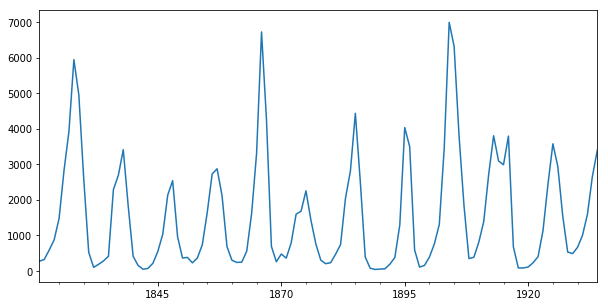

In [4]:
ts_lynx.plot(figsize=(10, 5))

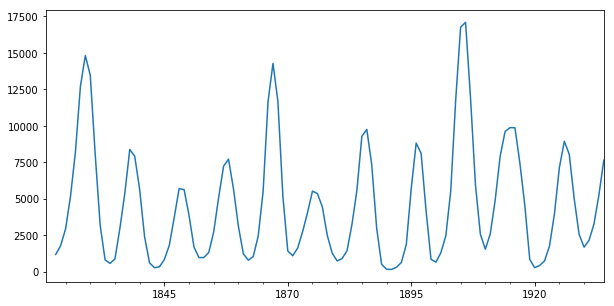

In [5]:
ts_lynx_ma = ts_lynx.rolling(3).sum()
ts_lynx_ma.plot(figsize=(10, 5))

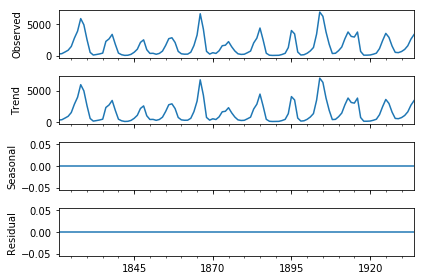

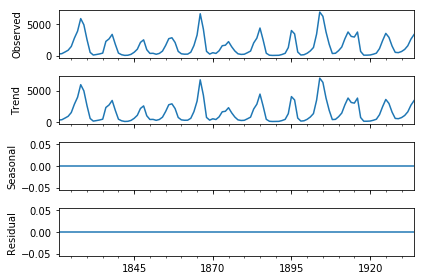

In [6]:
result = seasonal_decompose(ts_lynx)
result.plot()

# Weakly (Periodical)

Weekly data on US finished motor gasoline products supplied (in thousands of barrels per day) from February 1991 to May 2005.

In [7]:
ts_gasoline = pd.Series.from_csv("data/gasoline.csv")

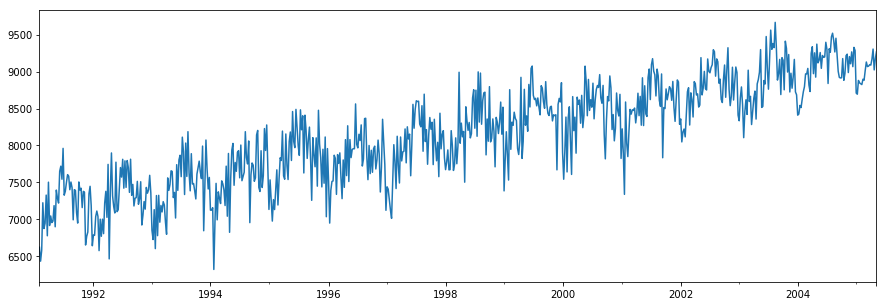

In [8]:
ts_gasoline.plot(figsize=(15, 5))

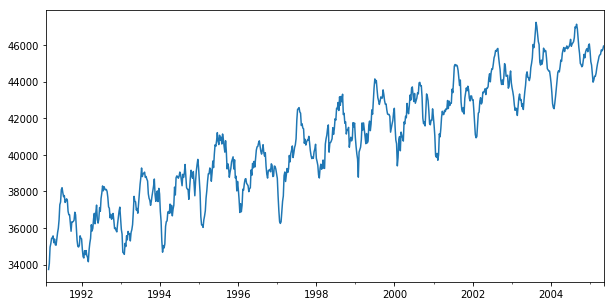

In [9]:
ts_gasoline_ma = ts_gasoline.rolling(5).sum()
ts_gasoline_ma.plot(figsize=(10, 5))

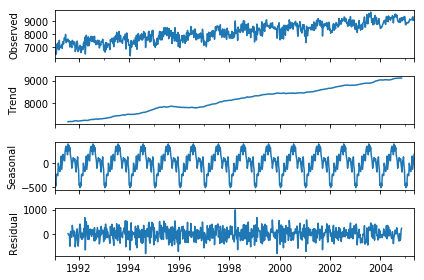

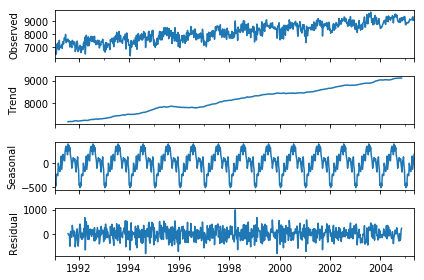

In [10]:
result = seasonal_decompose(ts_gasoline)
result.plot()

# Daily

Daily minimum temperatures in Melbourne, Australia, 1981-1990

In [11]:
ts_temprature = pd.Series.from_csv("data/temperatures.csv")

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:4137: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


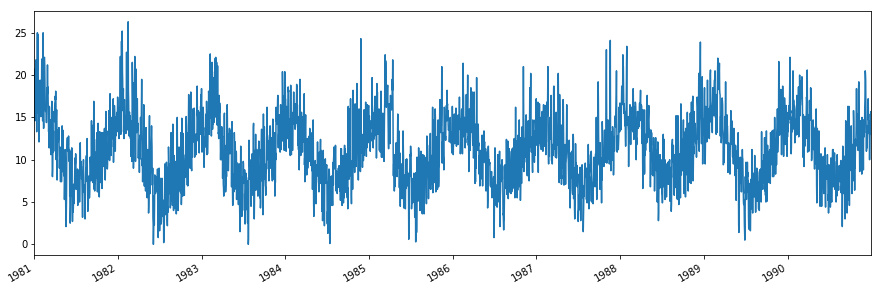

In [12]:
ts_temprature.plot(figsize=(15, 5))

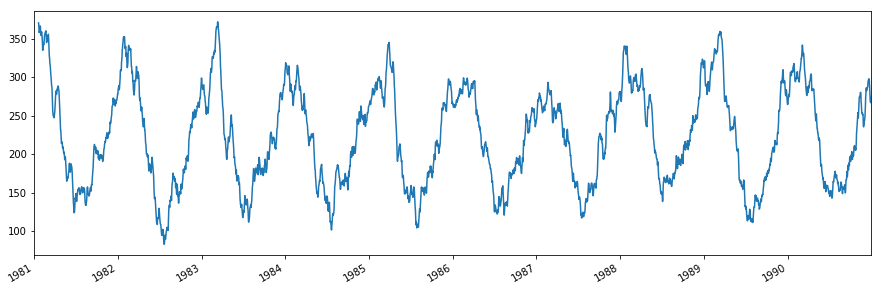

In [13]:
ts_temprature_ma = ts_temprature.rolling(20).sum()
ts_temprature_ma.plot(figsize=(15, 5))

# ARIMA

In [15]:
ts_missed = pd.Series.from_csv("data/champagne_missed.csv")

In [16]:
ts_missed.head()

1964-01-01    2815.0
1964-02-01    2672.0
1964-03-01    2755.0
1964-04-01    2721.0
1964-05-01    2946.0
dtype: float64

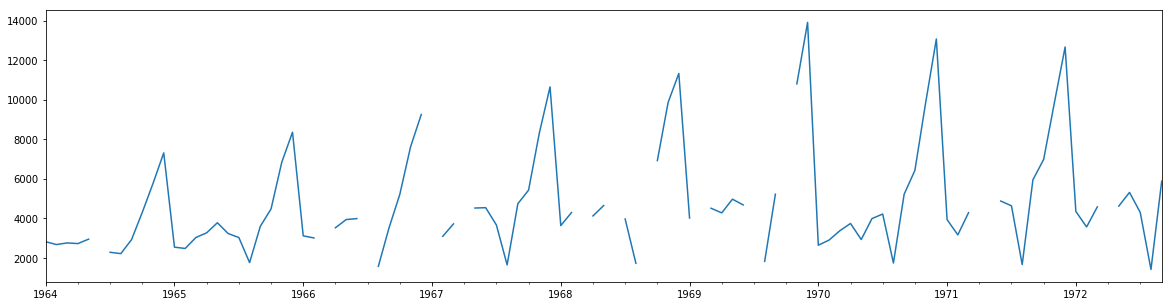

In [17]:
ts_missed.plot(figsize=(20, 5))

### Interpolation

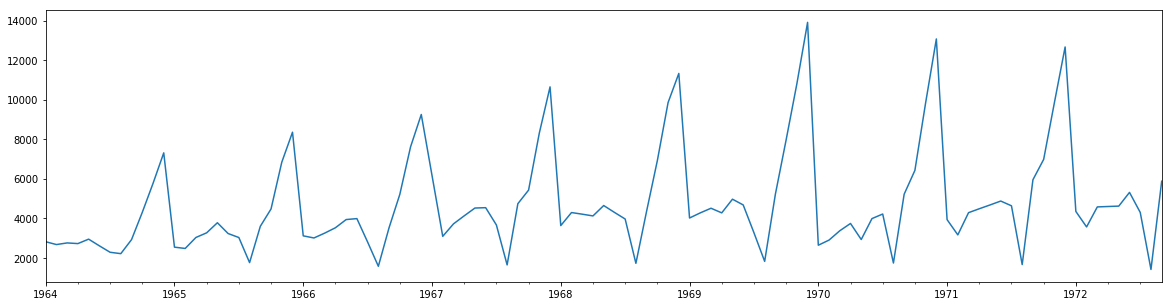

In [18]:
ts_missed.interpolate("time").plot(figsize=(20, 5))

### Linear Regresion

In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [20]:
ts_missed_cp = ts_missed

In [21]:
df = pd.DataFrame([
    [ ts_missed.iloc[i-12],
      ts_missed.iloc[i-1],
      ts_missed.iloc[i+1],
      ts_missed.iloc[i+12],  
      ts_missed.iloc[i]] 
     for i in range(11, len(ts_missed)-12)
], columns=["prev_year", "prev_month", "next_month", "next_year", "current"])

In [22]:
df_cp = df.dropna()

In [23]:
df_cp.head()

,prev_year,prev_month,next_month,next_year,current
0,5877.0,5764.0,2541.0,8357.0,7312.0
1,2815.0,7312.0,2475.0,3113.0,2541.0
2,2672.0,2541.0,3031.0,3006.0,2475.0
4,2721.0,3031.0,3776.0,3523.0,3266.0
5,2946.0,3266.0,3230.0,3937.0,3776.0


In [24]:
df_cp.shape

(35, 5)

In [25]:
lr = LinearRegression()
lr.fit(df_cp.loc[:, df_cp.columns != 'current'], df_cp["current"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
def get_value_by_index(ts, i):
    if i >=0 and i < len(ts) and not np.isnan(ts.iloc[i]):
        return ts.iloc[i]
    return ts.mean()

In [27]:
predictions = []
for i in range(len(ts_missed)):
    predict = lr.predict(np.array([
        get_value_by_index(ts_missed, i-12),
        get_value_by_index(ts_missed, i-1),
        get_value_by_index(ts_missed, i+1),
        get_value_by_index(ts_missed, i+12),
    ]).reshape(-1, 4))
    predictions.append(predict[0])
predictions = pd.Series(predictions, index=ts_missed.index)

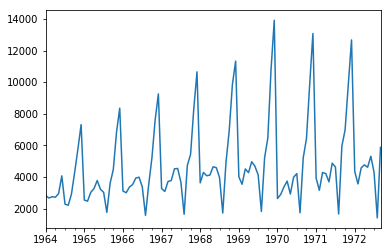

In [28]:
ts_filled = ts_missed.fillna(predictions)
ts_filled.plot()

# ARIMA

In [29]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

In [30]:
def test_stationary(ts):
    result = adfuller(ts)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [31]:
ts_train = ts_filled[ts_filled.index<"1971"]
ts_valid = ts_filled[ts_filled.index>="1971"]

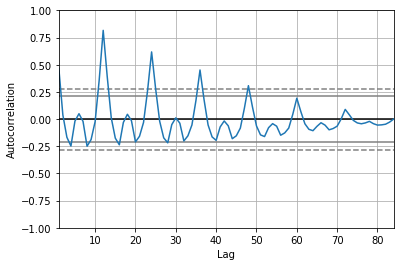

In [32]:
autocorrelation_plot(ts_train)

In [33]:
test_stationary(ts_train)

ADF Statistic: -1.993503
p-value: 0.289429
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


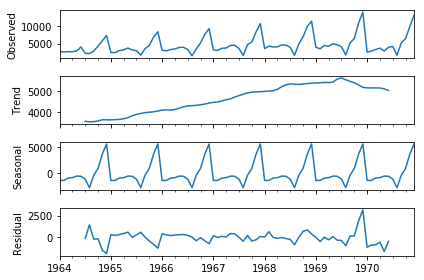

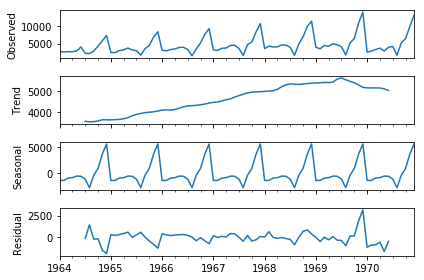

In [34]:
decompose = seasonal_decompose(ts_train)
decompose.plot()

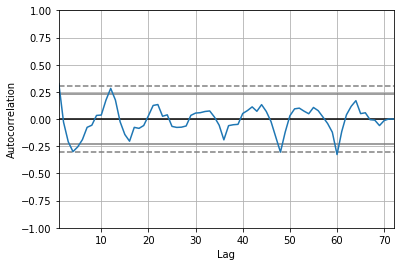

In [35]:
residuals = decompose.resid.dropna()
autocorrelation_plot(residuals)

In [36]:
test_stationary(residuals)

ADF Statistic: -6.750087
p-value: 0.000000
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


In [37]:
model = ARIMA(residuals, order=(1, 0, 1))
model_fit = model.fit()  

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


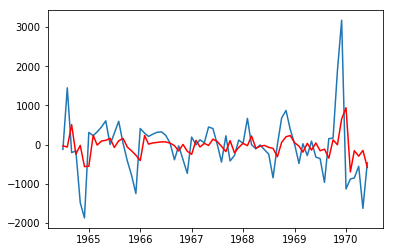

In [38]:
forecast = model_fit.fittedvalues
plt.plot(residuals)
plt.plot(forecast, color='red')
plt.show()

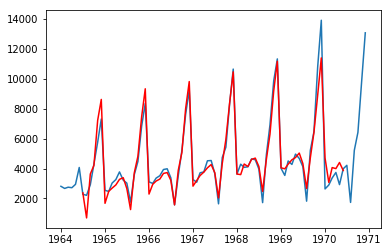

In [39]:
plt.plot(ts_train)
plt.plot(forecast.add(decompose.seasonal).add(decompose.trend).dropna(), color="red")

In [40]:
def grid_search(ts, p_values, d_values, q_values):
    best_aic = np.inf
    best_values = (-1, -1, -1)
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(ts, order=(p, d, q))
                    model_fit = model.fit(disp=0)
                    aic = ARIMAResults.aic(model_fit)
                    if aic < best_aic:
                        best_aic = aic
                        best_values = (p, d, q)
                    print("({},{},{}) - {}".format(p, d, q, aic))
                except: 
                    print("({},{},{}) - {}".format(p, d, q, "error"))
    print()
    print("Best: ")
    print("{} - {}".format(best_values, best_aic))

In [41]:
grid_search(residuals, range(3), range(3), range(3))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-

(0,0,0) - 1156.1344734809593
(0,0,1) - 1149.23407879662
(0,0,2) - 1151.1009903792658
(0,1,0) - 1161.9796030479124
(0,1,1) - 1147.3135687376875
(0,1,2) - 1139.996162853301
(0,2,0) - 1208.3274830376

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-


(0,2,1) - 1152.9088768627284
(0,2,2) - error
(1,0,0) - 1150.076671509032
(1,0,1) - 1151.1616138723607
(1,0,2) - error


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-

(1,1,0) - 1159.2774406976987
(1,1,1) - 1140.6051201817336
(1,1,2) - error
(1,2,0) - 1186.8070338280272
(1,2,1) - error
(1,2,2) - error


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-

(2,0,0) - 1150.3224567110678
(2,0,1) - 1133.4928393622426


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(2,0,2) - 1122.0615488513329
(2,1,0) - 1158.6661424709132
(2,1,1) - 1141.2079089583858


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-

(2,1,2) - error
(2,2,0) - 1177.8494937591697
(2,2,1) - 1150.464954734308
(2,2,2) - error

Best: 
(2, 0, 2) - 1122.0615488513329


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: 

In [418]:
model = ARIMA(residuals, order=(2, 0, 2))
model_fit = model.fit()  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


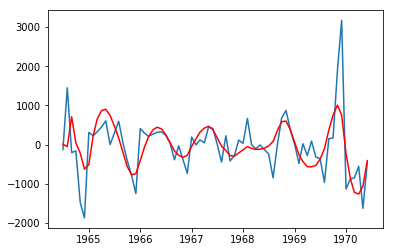

In [420]:
forecast = model_fit.fittedvalues
plt.plot(residuals)
plt.plot(forecast, color='red')
plt.show()

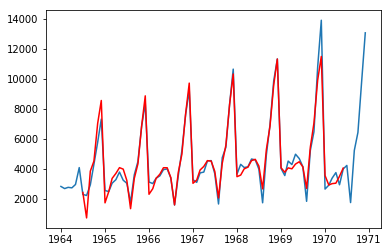

In [421]:
plt.plot(ts_train)
plt.plot(forecast.add(decompose.seasonal).add(decompose.trend).dropna(), color="red")